In [3]:
import pandas as pd

df = pd.read_csv("Data-GP1_with_features.csv")

In [4]:
import numpy as np
import pandas as pd

# Target: predict SALES (daily tickets sold)
TARGET = "Culmulative_sales"

df = df.copy()
df["y_log"] = np.log1p(df[TARGET])

# Candidate features (mirrors the price notebook, minus the target to avoid leakage)
num_feats = [
    "lead_time_days",
    "route_sales_rank", "sales_diff_1",  # keep if you allow using lags/prev-day signals
    "price_to_route_month_mean", "route_month_mean_price",
    "stringency_at_purchase",
]

bool_feats = [
    "isReturn","isOneway","isNormCabin",
    "is_weekend_dept","is_weekend_purchase",
    "is_sg_holiday_dept","is_us_holiday_dept","is_cn_holiday_dept",
    "is_fr_holiday_dept","is_in_holiday_dept","is_ru_holiday_dept",
    "is_sg_holiday_purchase","is_us_holiday_purchase","is_cn_holiday_purchase",
    "is_fr_holiday_purchase","is_in_holiday_purchase","is_ru_holiday_purchase",
    "return_x_norm","oneway_x_norm","return_x_weekend","oneway_x_weekend",
]

cat_feats = [
    "dept_weekday","purchase_weekday","dept_season",
    "Train_Number_All","Customer_Cat"
]

# Keep only columns that exist, and be sure not to include the target as a feature
num_feats = [c for c in num_feats if c in df.columns and c != TARGET]
bool_feats = [c for c in bool_feats if c in df.columns and c != TARGET]
cat_feats = [c for c in cat_feats if c in df.columns and c != TARGET]

X_cols = num_feats + bool_feats + cat_feats
print("Using features:", X_cols)


Using features: ['lead_time_days', 'route_sales_rank', 'sales_diff_1', 'price_to_route_month_mean', 'route_month_mean_price', 'isReturn', 'isOneway', 'isNormCabin', 'is_weekend_dept', 'is_weekend_purchase', 'is_sg_holiday_dept', 'is_us_holiday_dept', 'is_cn_holiday_dept', 'is_fr_holiday_dept', 'is_in_holiday_dept', 'is_ru_holiday_dept', 'is_sg_holiday_purchase', 'is_us_holiday_purchase', 'is_cn_holiday_purchase', 'is_fr_holiday_purchase', 'is_in_holiday_purchase', 'is_ru_holiday_purchase', 'return_x_norm', 'oneway_x_norm', 'return_x_weekend', 'oneway_x_weekend', 'dept_weekday', 'purchase_weekday', 'dept_season', 'Train_Number_All', 'Customer_Cat']


Time-aware train/test split

Don’t shuffle randomly when there’s time involved.

In [5]:
# Ensure dates are datetime
for c in ["Purchase_Date","Dept_Date"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

df_sorted = df.sort_values("Purchase_Date").reset_index(drop=True)

cut = int(len(df_sorted) * 0.8)  # 80% train, 20% test (time ordered)
train = df_sorted.iloc[:cut].copy()
test  = df_sorted.iloc[cut:].copy()

X_train, y_train = train[X_cols], train["y_log"]
X_test,  y_test  = test[X_cols],  test["y_log"]

print(train["Purchase_Date"].min(), "→", train["Purchase_Date"].max(), "| TRAIN")
print(test["Purchase_Date"].min(),  "→", test["Purchase_Date"].max(),  "| TEST")


2018-06-01 00:00:00 → 2019-04-22 00:00:00 | TRAIN
2019-04-22 00:00:00 → 2019-06-30 00:00:00 | TEST


Preprocess + LASSO (with CV)

Scale numeric/boolean, one-hot categoricals, and run LassoCV.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
import numpy as np

numeric = num_feats + bool_feats  # scale numeric + 0/1 flags
categorical = cat_feats

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
    ],
    remainder="drop"
)

alphas = np.logspace(-4, 1.5, 80)  # search ~1e-4 to ~31
lasso = LassoCV(alphas=alphas, cv=5, random_state=42, n_jobs=-1, max_iter=20000)

pipe_lasso = Pipeline([
    ("pre", pre),
    ("model", lasso)
])

pipe_lasso.fit(X_train, y_train)

print("Best alpha (LASSO):", pipe_lasso.named_steps["model"].alpha_)
print("Non-zero coefs:", np.sum(pipe_lasso.named_steps["model"].coef_ != 0))


Best alpha (LASSO): 0.0002616504698748821
Non-zero coefs: 45


Evaluate (log space + back-transform)

Report MAE/RMSE/ MAP E on the original price scale.

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(pipe, X_tr, y_tr, X_te, y_te, label="Model"):
    # predictions in log1p space
    pred_tr = pipe.predict(X_tr)
    pred_te = pipe.predict(X_te)

    # true values (original scale)
    y_tr_true = np.expm1(y_tr)
    y_te_true = np.expm1(y_te)

    # naive back-transform
    y_tr_hat_naive = np.expm1(pred_tr)
    y_te_hat_naive = np.expm1(pred_te)

    # Duan smearing correction for log1p models
    resid_tr = y_tr - pred_tr                       # residuals in log space
    smear = float(np.mean(np.exp(resid_tr)))        # E[exp(e)]
    y_tr_hat_smear = smear * np.exp(pred_tr) - 1.0
    y_te_hat_smear = smear * np.exp(pred_te) - 1.0

    # clip tiny negatives
    y_tr_hat_naive = np.clip(y_tr_hat_naive, 0, None)
    y_te_hat_naive = np.clip(y_te_hat_naive, 0, None)
    y_tr_hat_smear = np.clip(y_tr_hat_smear, 0, None)
    y_te_hat_smear = np.clip(y_te_hat_smear, 0, None)

    def rmse(y_true, y_pred):
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

    def mape(y_true, y_pred):
        return float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100)

    metrics = {
        # log-space fit (your original intent)
        "R2_tr_log": r2_score(y_tr, pred_tr),
        "R2_te_log": r2_score(y_te, pred_te),

        # original-scale (naive back-transform)
        "MAE_tr": mean_absolute_error(y_tr_true, y_tr_hat_naive),
        "RMSE_tr": rmse(y_tr_true, y_tr_hat_naive),
        "MAPE_tr_%": mape(y_tr_true, y_tr_hat_naive),
        "R2_tr_orig": r2_score(y_tr_true, y_tr_hat_naive),

        "MAE_te": mean_absolute_error(y_te_true, y_te_hat_naive),
        "RMSE_te": rmse(y_te_true, y_te_hat_naive),
        "MAPE_te_%": mape(y_te_true, y_te_hat_naive),
        "R2_te_orig": r2_score(y_te_true, y_te_hat_naive),

        # smearing-corrected (often better calibrated)
        "MAE_te_smear": mean_absolute_error(y_te_true, y_te_hat_smear),
        "RMSE_te_smear": rmse(y_te_true, y_te_hat_smear),
        "MAPE_te_smear_%": mape(y_te_true, y_te_hat_smear),
        "R2_te_orig_smear": r2_score(y_te_true, y_te_hat_smear),

        "SmearingFactor": smear,
    }

    print(label, metrics)
    return metrics

# usage
m_lasso = evaluate(pipe_lasso, X_train, y_train, X_test, y_test, "LASSO")


LASSO {'R2_tr_log': 0.9485811049455068, 'R2_te_log': 0.950243796623579, 'MAE_tr': 3.4820485810483692, 'RMSE_tr': 8.193981879706076, 'MAPE_tr_%': 22.725564522526312, 'R2_tr_orig': 0.8150330695833223, 'MAE_te': 4.1205054314519485, 'RMSE_te': 8.904420353163447, 'MAPE_te_%': 26.07015161909582, 'R2_te_orig': 0.8407186184199342, 'MAE_te_smear': 4.429821224289429, 'RMSE_te_smear': 9.624903937190064, 'MAPE_te_smear_%': 28.461833913844753, 'R2_te_orig_smear': 0.8138999396188308, 'SmearingFactor': 1.0344097171562976}


Which features did LASSO keep?

Get feature names after preprocessing and list non-zero coefficients (standardized).

In [8]:
import numpy as np
import pandas as pd

# Get feature names after preprocessing
ohe = pipe_lasso.named_steps["pre"].named_transformers_["cat"]
cat_names = []
if hasattr(ohe, "get_feature_names_out"):
    cat_names = list(ohe.get_feature_names_out(cat_feats))
else:
    # Fallback in older sklearn
    cat_names = []
num_names = numeric

feat_names = num_names + cat_names

coefs = pipe_lasso.named_steps["model"].coef_
keep_mask = coefs != 0
kept = [(feat_names[i], coefs[i]) for i in range(len(coefs)) if keep_mask[i]]

# Standardize coefficients (already standardized for numeric/booleans; OHE are as-is)
df_kept = pd.DataFrame(kept, columns=["feature","coef_std"]).sort_values("coef_std", ascending=False)

print(f"LASSO kept {len(df_kept)} / {len(feat_names)} features")
df_kept.head(30)


LASSO kept 45 / 61 features


,feature,coef_std
1,route_sales_rank,1.096806e+00
39,Train_Number_All_K,2.316592e-01
41,Train_Number_All_M,2.264746e-01
33,Train_Number_All_D,1.126999e-01
38,Train_Number_All_J,1.019788e-01
30,Train_Number_All_A,9.676861e-02
40,Train_Number_All_L,9.564199e-02
42,Train_Number_All_N,4.702394e-02
29,dept_season_Winter,1.827122e-02
23,dept_weekday_Friday,1.678413e-02


Human-readable formula

Coefficients above are for standardized inputs. To get a simple linear formula in original units, refit a plain LinearRegression on only the selected columns using the same one-hot, but without scaling numeric features.

In [11]:
# Refit a plain LinearRegression on ONLY the LASSO-selected columns
# using one-hot encoding for categoricals (no numeric scaling).
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Names from the LASSO pipeline
ohe = pipe_lasso.named_steps["pre"].named_transformers_.get("cat", None)
cat_names = (
    ohe.get_feature_names_out(categorical)
    if (ohe is not None and hasattr(ohe, "get_feature_names_out") and categorical)
    else np.array([])
)
feat_names = np.array(list(numeric) + list(cat_names))

# Mask of columns LASSO kept
coefs = pipe_lasso.named_steps["model"].coef_
mask = coefs != 0
selected_names = feat_names[mask]

# Build a "readable" preprocessor: passthrough numeric, OHE categoricals
pre_readable = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
    ],
    remainder="drop",
)

# Fit/transform train features
Xtr2 = pre_readable.fit_transform(X_train)

# Align transformed column names with this encoder
ohe2 = pre_readable.named_transformers_.get("cat", None)
cat_names2 = (
    ohe2.get_feature_names_out(categorical)
    if (ohe2 is not None and hasattr(ohe2, "get_feature_names_out") and categorical)
    else np.array([])
)
feat_names2 = np.array(list(numeric) + list(cat_names2))

# Keep only LASSO-selected columns
selector = np.isin(feat_names2, selected_names)
Xtr2_sel = Xtr2[:, selector]
feat_names_sel = feat_names2[selector]

# Refit linear model on log-sales (y_train already = log1p(SALES))
lin = LinearRegression()
lin.fit(Xtr2_sel, y_train)

print("Linear model (log-sales) with selected features")
print("Intercept:", lin.intercept_)
pd.DataFrame(
    {"feature": feat_names_sel, "coef": lin.coef_}
).sort_values("coef", key=lambda s: np.abs(s), ascending=False).head(30)


Linear model (log-sales) with selected features
Intercept: 0.7994945005441145


,feature,coef
31,Train_Number_All_B,-0.371907
34,Train_Number_All_E,-0.340393
36,Train_Number_All_G,-0.248665
39,Train_Number_All_K,0.243955
41,Train_Number_All_M,0.237011
33,Train_Number_All_D,0.119258
40,Train_Number_All_L,0.115413
38,Train_Number_All_J,0.110919
30,Train_Number_All_A,0.106757
42,Train_Number_All_N,0.076910


log(1+sales)=0.7995−0.372(Train_B)−0.340(Train_E)−0.249(Train_G)+0.244(Train_K)+0.237(Train_M)+0.119(Train_D)+0.116(Train_L)+0.111(Train_J)+0.107(Train_A)+0.077(Train_N)−0.069(isOneway)+0.062(oneway_x_norm)…

sales
=exp(0.7995+i∑​βi​Xi​)−1

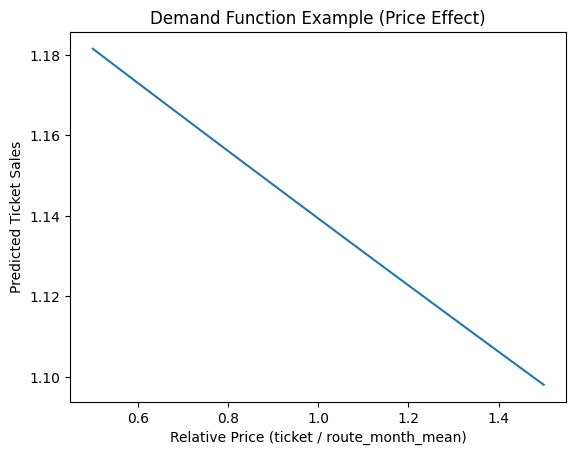

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Example: vary relative price, hold others at 0
beta0 = 0.7995
coef_price = -0.039008

# Range of relative price (price / route_month_mean)
x = np.linspace(0.5, 1.5, 100)  # 50% to 150% of route avg
y_log = beta0 + coef_price * x
y_pred = np.exp(y_log) - 1

plt.plot(x, y_pred)
plt.xlabel("Relative Price (ticket / route_month_mean)")
plt.ylabel("Predicted Ticket Sales")
plt.title("Demand Function Example (Price Effect)")
plt.show()


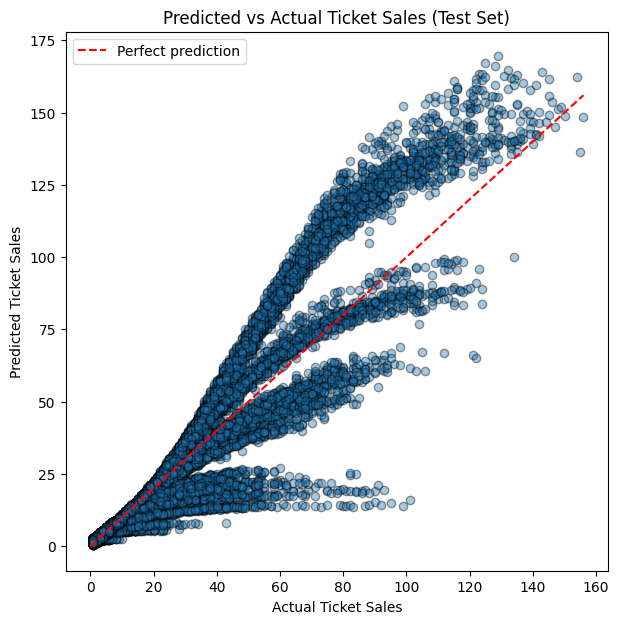

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set (refitted LinearRegression)
y_pred_log = lin.predict(pre_readable.transform(X_test)[:, selector])
y_pred = np.exp(y_pred_log) - 1   # back-transform

# True values
y_true = np.expm1(y_test)  # since y_test was log1p(sales)

plt.figure(figsize=(7,7))
plt.scatter(y_true, y_pred, alpha=0.4, edgecolor="k")
plt.plot([0, max(y_true)], [0, max(y_true)], "r--", label="Perfect prediction")
plt.xlabel("Actual Ticket Sales")
plt.ylabel("Predicted Ticket Sales")
plt.title("Predicted vs Actual Ticket Sales (Test Set)")
plt.legend()
plt.show()


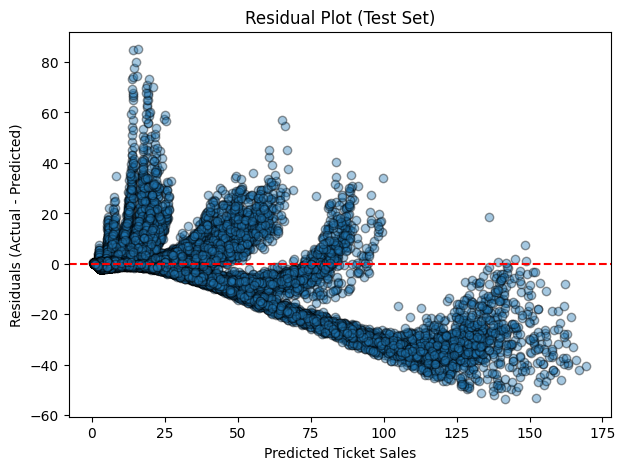

In [14]:
residuals = y_true - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.4, edgecolor="k")
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted Ticket Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Test Set)")
plt.show()
